In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.feature_extraction.text import CountVectorizer
import datetime


In [ ]:
# Load social media sentiment data
social_data = pd.read_csv(r"C:\Users\INDHUMATHI\Downloads\sentiment analysis\sentimentdataset.csv")

# Load sales data
sales_data = pd.read_csv(r"C:\Users\INDHUMATHI\Downloads\sales data.csv\Online Sales Data.csv")



In [ ]:
social_data.head()

Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                                Text    Sentiment  \
0   Enjoying a beautiful day at the park!        ...   Positive     
1   Traffic was terrible this morning.           ...   Negative     
2   Just finished an amazing workout! 💪          ...   Positive     
3   Excited about the upcoming weekend getaway!  ...   Positive     
4   Trying out a new recipe for dinner tonight.  ...   Neutral      

             Timestamp            User     Platform  \
0  2023-01-15 12:30:00   User123          Twitter     
1  2023-01-15 08:45:00   CommuterX        Twitter     
2  2023-01-15 15:45:00   FitnessFan      Instagram    
3  2023-01-15 18:20:00   AdventureX       Facebook    
4  2023-01-15 19:55:00   ChefCook        Instagram    

                                     Hashtags  Retweets  Likes       Country  \
0   #Nature #Park                                  15.0   30.0     USA         
1   #Traffic #Morning                               5.0   10.0     Canada      
2   #Fitness #Workout                              20.0   40.0   USA           
3   #Travel #Adventure                              8.0   15.0     UK          
4   #Cooking #Food                                 12.0   25.0    Australia    

   Year  Month  Day  Hour  
0  2023      1   15    12  
1  2023      1   15     8  
2  2023      1   15    15  
3  2023      1   15    18  
4  2023      1   15    19

In [ ]:
social_data.drop(columns=['Unnamed: 0.1','Unnamed: 0'],inplace=True)

In [ ]:
sales_data.sample(5)

Transaction ID       Date Product Category  \
2             10003 2024-01-03         Clothing   
151           10152 2024-05-31  Home Appliances   
153           10154 2024-06-02            Books   
51            10052 2024-02-21            Books   
100           10101 2024-04-10  Beauty Products   

                               Product Name  Units Sold  Unit Price  \
2                          Levi's 501 Jeans           3       69.99   
151             Ninja Foodi Pressure Cooker           2      199.99   
153    The Night Circus by Erin Morgenstern           2       16.99   
51   The Silent Patient by Alex Michaelides           2       26.99   
100   Kiehl's Midnight Recovery Concentrate           1       82.00   

     Total Revenue         Region Payment Method  Sales  
2           209.97           Asia     Debit Card      3  
151         399.98         Europe         PayPal      2  
153          33.98  North America    Credit Card      2  
51           53.98  North America    Credit Card      2  
100          82.00         Europe         PayPal      1

In [ ]:
social_data[['Date', 'Time']] = social_data['Timestamp'].str.split(" ", expand=True)


In [ ]:
social_data['Date'] = pd.to_datetime(social_data['Date'], errors='coerce')
sales_data['Date'] = pd.to_datetime(sales_data['Date'], errors='coerce')


In [ ]:
# Clean text function
def clean_text(Text):
    Text = re.sub(r"http\S+", "", Text)  # Remove URLs
    Text = re.sub(r"[^a-zA-Z ]", "", Text)  # Remove non-alphanumeric characters
    Text = Text.lower()  # Convert text to lowercase
    return Text


social_data['cleaned_text'] = social_data['Text'].apply(clean_text)
print(social_data[['Text', 'cleaned_text']].head())


                                                Text  \
0   Enjoying a beautiful day at the park!        ...   
1   Traffic was terrible this morning.           ...   
2   Just finished an amazing workout! 💪          ...   
3   Excited about the upcoming weekend getaway!  ...   
4   Trying out a new recipe for dinner tonight.  ...   

                                        cleaned_text  
0   enjoying a beautiful day at the park         ...  
1   traffic was terrible this morning            ...  
2   just finished an amazing workout                  
3   excited about the upcoming weekend getaway   ...  
4   trying out a new recipe for dinner tonight   ...  


In [ ]:
sales_data['Sales']=sales_data['Units Sold']
social_data['Sales']=social_data['Retweets']

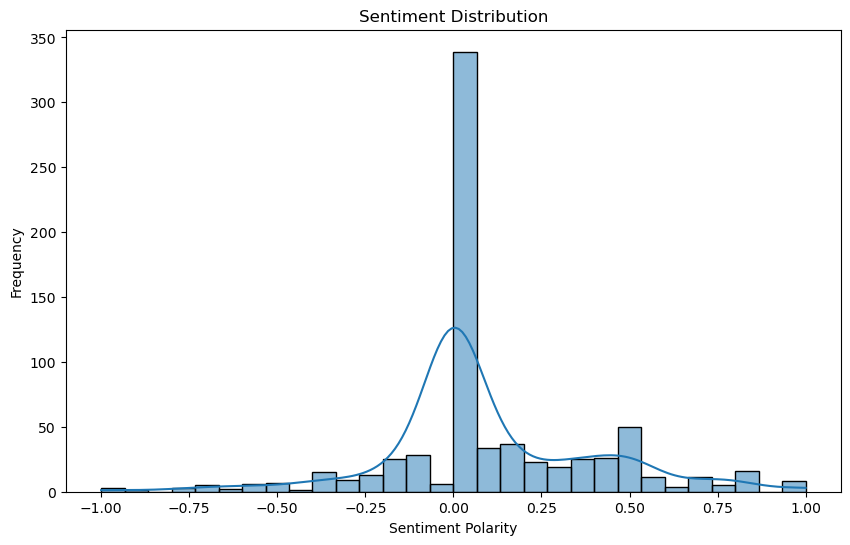

In [ ]:
# Sentiment Analysis using TextBlob
social_data['sentiment'] = social_data['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Display sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(social_data['sentiment'], kde=True, bins=30)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


In [ ]:

sales_data.isnull().sum()
sales_data.dropna(inplace=True)
print(sales_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    240 non-null    int64         
 1   Date              240 non-null    datetime64[ns]
 2   Product Category  240 non-null    object        
 3   Product Name      240 non-null    object        
 4   Units Sold        240 non-null    int64         
 5   Unit Price        240 non-null    float64       
 6   Total Revenue     240 non-null    float64       
 7   Region            240 non-null    object        
 8   Payment Method    240 non-null    object        
 9   Sales             240 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 18.9+ KB
None


In [ ]:
# Aggregate sentiment data by date
social_data['Date'] = pd.to_datetime(social_data['Date'])
daily_sentiment = social_data.groupby('Date')['sentiment'].mean().reset_index()

# Merge sentiment data with sales data
merged_data = pd.merge(sales_data, daily_sentiment, on='Date', how='inner')

# Display merged data
print(merged_data.head())


Empty DataFrame
Columns: [Transaction ID, Date, Product Category, Product Name, Units Sold, Unit Price, Total Revenue, Region, Payment Method, Sales, sentiment]
Index: []


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    0 non-null      int64         
 1   Date              0 non-null      datetime64[ns]
 2   Product Category  0 non-null      object        
 3   Product Name      0 non-null      object        
 4   Units Sold        0 non-null      int64         
 5   Unit Price        0 non-null      float64       
 6   Total Revenue     0 non-null      float64       
 7   Region            0 non-null      object        
 8   Payment Method    0 non-null      object        
 9   Sales             0 non-null      int64         
 10  sentiment         0 non-null      float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 132.0+ bytes


In [ ]:
merged_data.shape

(0, 11)

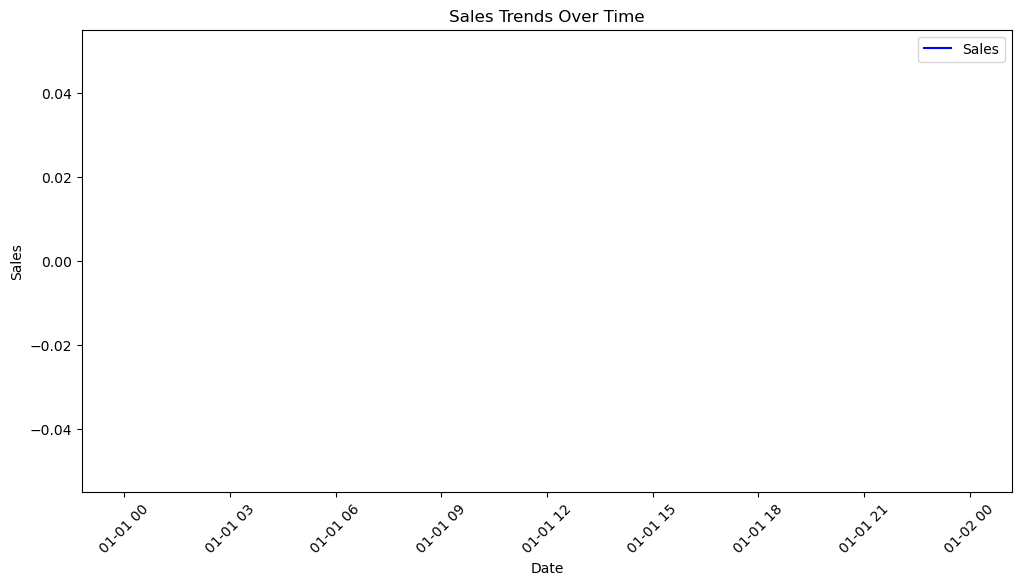

In [ ]:
# Plot sales trends over time
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], merged_data['Sales'], label='Sales', color='blue')
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()


c:\Users\INDHUMATHI\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\INDHUMATHI\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


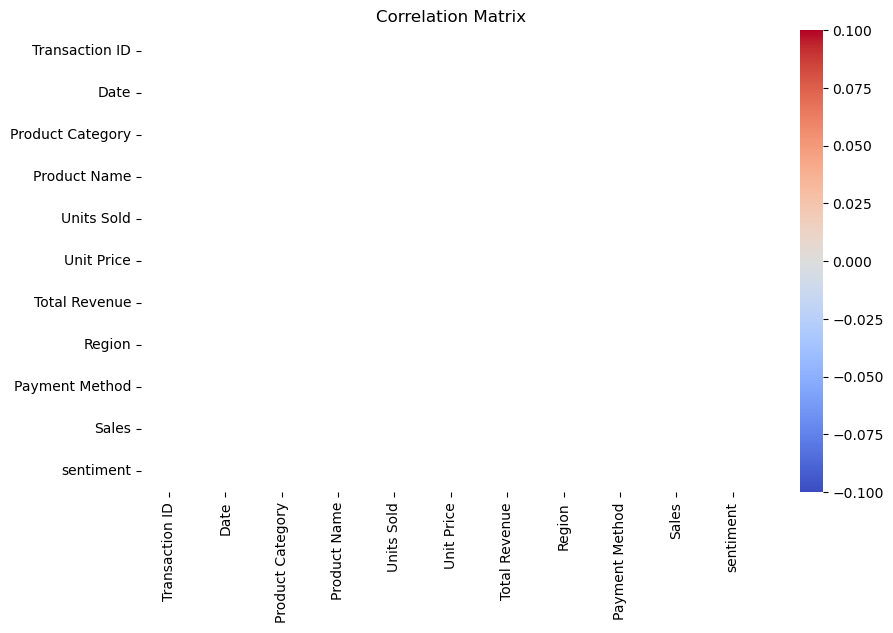

In [ ]:
# Calculate correlations
correlation_matrix = merged_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Add rolling averages
merged_data['sales_rolling_mean'] = merged_data['Sales'].rolling(window=7).mean()
merged_data['sentiment_rolling_mean'] = merged_data['sentiment'].rolling(window=7).mean()

# Add lag features (previous day sentiment and sales)
merged_data['sentiment_lag'] = merged_data['sentiment'].shift(1)
merged_data['sales_lag'] = merged_data['Sales'].shift(1)

# Drop rows with NaN values
merged_data.dropna(inplace=True)

# Display updated data
print(merged_data[['Date', 'Sales', 'sentiment', 'sales_rolling_mean', 'sentiment_rolling_mean', 'sentiment_lag', 'sales_lag']].head())


Empty DataFrame
Columns: [Date, Sales, sentiment, sales_rolling_mean, sentiment_rolling_mean, sentiment_lag, sales_lag]
Index: []


In [ ]:
# Convert sentiment to binary (positive = 1, negative = 0)
social_data['sentiment_binary'] = (social_data['sentiment'] > 0).astype(int)

# Split data into train and test sets
X = social_data['cleaned_text']
y = social_data['sentiment_binary']

# Vectorize text data
vectorizer = CountVectorizer(max_features=1000)
X_vectorized = vectorizer.fit_transform(X).toarray()

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.93      0.86        88
           1       0.86      0.64      0.74        59

    accuracy                           0.82       147
   macro avg       0.83      0.79      0.80       147
weighted avg       0.82      0.82      0.81       147



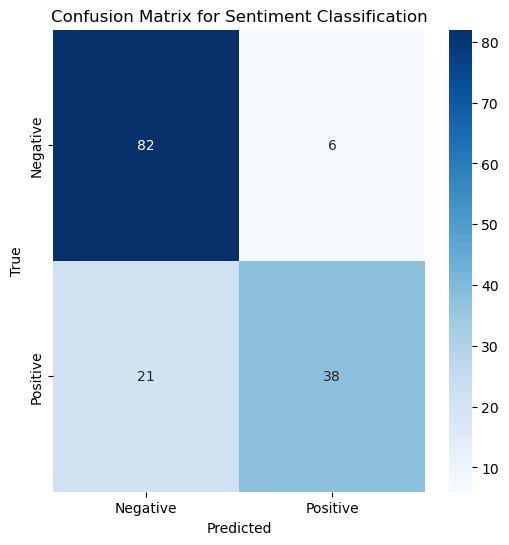

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for Sentiment Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
pip install dash

   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/7.8 MB 656.4 kB/s eta 0:00:12
   ---------------------------------------- 0.1/7.8 MB 751.6 kB/s eta 0:00:11
   - -------------------------------------- 0.2/7.8 MB 1.0 MB/s eta 0:00:08
   - -------------------------------------- 0.2/7.8 MB 962.7 kB/s eta 0:00:08
   - -------------------------------------- 0.3/7.8 MB 983.9 kB/s eta 0:00:08
   - -------------------------------------- 0.3/7.8 MB 1.1 MB/s eta 0:00:07
   -- ------------------------------------- 0.4/7.8 MB 1.2 MB/s eta 0:00:07
   -- ------------------------------------- 0.5/7.8 MB 1.1 MB/s eta 0:00:07
   -- ------------------------------------- 0.5/7.8 MB 1.1 MB/s eta 0:00:07
   --- ------------------------------------ 0.6/7.8 MB 1.2 MB/s eta 0:00:06
   --- ------------------------------------ 0.7/7.8 MB 1.2 MB/s eta 0:00:06
   --- -----------

In [ ]:
import dash
from dash import dcc, html

# Initialize Dash app
app = dash.Dash(__name__)

# Layout
app.layout = html.Div([
    html.H1("Social Media Sentiment and Sales Prediction Dashboard"),
    dcc.Graph(id='sentiment-sales-plot'),
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)
